In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

import pandas as pd
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

from lips.config import ConfigManager
from lips.utils import get_path

# 1. l2rpn_case14_sandbox grid

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## 1.1 Benchmark2: Risk assessment through contingency screening

In [3]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark2", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["train"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
kwargs_tau

[(5, (1, 1, 2, 2, 1, 2, 2)),
 (4, (2, 1, 2, 1, 2)),
 (3, (2, 1, 1, 2, 1, 2)),
 (8, (2, 1, 1, 2, 2)),
 (1, (1, 2, 1, 2, 2, 2))]

## LeapNet

In [5]:
leap_net2 = LeapNet(name="tf_leapnet",
                                      
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark2",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,

                   loss = {"name": "mse"},
                   lr = 1e-4,
                   activation = tf.keras.layers.LeakyReLU(alpha=0.01),
                    
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   concatenate_tau = True,

                   layer = "resnet",
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   scaler = PowerGridScaler,
                   
                   )


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../leap_net/proxy/proxyLeapNet.py:147: UserWarning: We strongly recommend you to get the "line_status" as an input vector
  warnings.warn("We strongly recommend you to get the \"line_status\" as an input vector")


In [6]:
import time
start_time = time.time()

In [7]:
leap_net2.train(train_dataset=benchmark2.train_dataset,
                val_dataset=benchmark2.val_dataset,
                batch_size = 128,
                epochs = 800)

2022-07-22 14:06:24.859022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:06:25.265920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c3:00.0, compute capability: 8.6


Epoch 1/800
  19/1172 [..............................] - ETA: 10s - loss: 43.7923 - a_or_hat_loss: 7.9953 - a_ex_hat_loss: 8.5352 - p_or_hat_loss: 12.3431 - p_ex_hat_loss: 13.6461 - v_or_hat_loss: 0.5957 - v_ex_hat_loss: 0.6768 - a_or_hat_mae: 2.4322 - a_ex_hat_mae: 2.5531 - p_or_hat_mae: 1.6231 - p_ex_hat_mae: 1.7189 - v_or_hat_mae: 0.7059 - v_ex_hat_mae: 0.7405  

2022-07-22 14:06:39.926348: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 14s 10ms/step - loss: 2.8655 - a_or_hat_loss: 0.4147 - a_ex_hat_loss: 0.4327 - p_or_hat_loss: 0.9532 - p_ex_hat_loss: 0.9932 - v_or_hat_loss: 0.0351 - v_ex_hat_loss: 0.0366 - a_or_hat_mae: 0.3235 - a_ex_hat_mae: 0.3270 - p_or_hat_mae: 0.3091 - p_ex_hat_mae: 0.3100 - v_or_hat_mae: 0.1033 - v_ex_hat_mae: 0.1032 - val_loss: 0.6105 - val_a_or_hat_loss: 0.0739 - val_a_ex_hat_loss: 0.0719 - val_p_or_hat_loss: 0.2339 - val_p_ex_hat_loss: 0.2236 - val_v_or_hat_loss: 0.0036 - val_v_ex_hat_loss: 0.0036 - val_a_or_hat_mae: 0.1549 - val_a_ex_hat_mae: 0.1538 - val_p_or_hat_mae: 0.1668 - val_p_ex_hat_mae: 0.1642 - val_v_or_hat_mae: 0.0405 - val_v_ex_hat_mae: 0.0393
Epoch 2/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.3907 - a_or_hat_loss: 0.0475 - a_ex_hat_loss: 0.0463 - p_or_hat_loss: 0.1496 - p_ex_hat_loss: 0.1421 - v_or_hat_loss: 0.0026 - v_ex_hat_loss: 0.0025 - a_or_hat_mae: 0.1242 - a_ex_hat_mae: 0.1221 - p_or_hat_mae: 0.1

1172/1172 [==============================] - 12s 10ms/step - loss: 0.0195 - a_or_hat_loss: 0.0042 - a_ex_hat_loss: 0.0038 - p_or_hat_loss: 0.0058 - p_ex_hat_loss: 0.0054 - v_or_hat_loss: 2.1184e-04 - v_ex_hat_loss: 1.9055e-04 - a_or_hat_mae: 0.0408 - a_ex_hat_mae: 0.0391 - p_or_hat_mae: 0.0351 - p_ex_hat_mae: 0.0336 - v_or_hat_mae: 0.0096 - v_ex_hat_mae: 0.0092 - val_loss: 0.0203 - val_a_or_hat_loss: 0.0051 - val_a_ex_hat_loss: 0.0042 - val_p_or_hat_loss: 0.0057 - val_p_ex_hat_loss: 0.0050 - val_v_or_hat_loss: 2.0288e-04 - val_v_ex_hat_loss: 1.8323e-04 - val_a_or_hat_mae: 0.0447 - val_a_ex_hat_mae: 0.0398 - val_p_or_hat_mae: 0.0329 - val_p_ex_hat_mae: 0.0305 - val_v_or_hat_mae: 0.0100 - val_v_ex_hat_mae: 0.0095
Epoch 24/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0187 - a_or_hat_loss: 0.0040 - a_ex_hat_loss: 0.0037 - p_or_hat_loss: 0.0055 - p_ex_hat_loss: 0.0051 - v_or_hat_loss: 2.0098e-04 - v_ex_hat_loss: 1.8568e-04 - a_or_hat_mae: 0.0403 - a_ex_hat_mae: 0

1172/1172 [==============================] - 11s 10ms/step - loss: 0.0114 - a_or_hat_loss: 0.0025 - a_ex_hat_loss: 0.0024 - p_or_hat_loss: 0.0032 - p_ex_hat_loss: 0.0030 - v_or_hat_loss: 1.2057e-04 - v_ex_hat_loss: 1.1381e-04 - a_or_hat_mae: 0.0325 - a_ex_hat_mae: 0.0316 - p_or_hat_mae: 0.0260 - p_ex_hat_mae: 0.0252 - v_or_hat_mae: 0.0072 - v_ex_hat_mae: 0.0070 - val_loss: 0.0104 - val_a_or_hat_loss: 0.0027 - val_a_ex_hat_loss: 0.0024 - val_p_or_hat_loss: 0.0026 - val_p_ex_hat_loss: 0.0025 - val_v_or_hat_loss: 7.5588e-05 - val_v_ex_hat_loss: 7.0289e-05 - val_a_or_hat_mae: 0.0338 - val_a_ex_hat_mae: 0.0309 - val_p_or_hat_mae: 0.0254 - val_p_ex_hat_mae: 0.0245 - val_v_or_hat_mae: 0.0059 - val_v_ex_hat_mae: 0.0059
Epoch 46/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0146 - a_or_hat_loss: 0.0031 - a_ex_hat_loss: 0.0029 - p_or_hat_loss: 0.0043 - p_ex_hat_loss: 0.0040 - v_or_hat_loss: 1.5652e-04 - v_ex_hat_loss: 1.5056e-04 - a_or_hat_mae: 0.0352 - a_ex_hat_mae: 0

1172/1172 [==============================] - 11s 9ms/step - loss: 0.0097 - a_or_hat_loss: 0.0021 - a_ex_hat_loss: 0.0020 - p_or_hat_loss: 0.0028 - p_ex_hat_loss: 0.0026 - v_or_hat_loss: 1.0242e-04 - v_ex_hat_loss: 9.1376e-05 - a_or_hat_mae: 0.0296 - a_ex_hat_mae: 0.0291 - p_or_hat_mae: 0.0235 - p_ex_hat_mae: 0.0230 - v_or_hat_mae: 0.0063 - v_ex_hat_mae: 0.0062 - val_loss: 0.0264 - val_a_or_hat_loss: 0.0044 - val_a_ex_hat_loss: 0.0045 - val_p_or_hat_loss: 0.0082 - val_p_ex_hat_loss: 0.0088 - val_v_or_hat_loss: 2.4282e-04 - val_v_ex_hat_loss: 2.1388e-04 - val_a_or_hat_mae: 0.0440 - val_a_ex_hat_mae: 0.0448 - val_p_or_hat_mae: 0.0396 - val_p_ex_hat_mae: 0.0414 - val_v_or_hat_mae: 0.0110 - val_v_ex_hat_mae: 0.0104
Epoch 68/800
1172/1172 [==============================] - 11s 9ms/step - loss: 0.0134 - a_or_hat_loss: 0.0027 - a_ex_hat_loss: 0.0026 - p_or_hat_loss: 0.0040 - p_ex_hat_loss: 0.0039 - v_or_hat_loss: 1.3135e-04 - v_ex_hat_loss: 1.1970e-04 - a_or_hat_mae: 0.0326 - a_ex_hat_mae: 0.0

1172/1172 [==============================] - 11s 9ms/step - loss: 0.0105 - a_or_hat_loss: 0.0022 - a_ex_hat_loss: 0.0021 - p_or_hat_loss: 0.0031 - p_ex_hat_loss: 0.0030 - v_or_hat_loss: 9.0496e-05 - v_ex_hat_loss: 8.0871e-05 - a_or_hat_mae: 0.0300 - a_ex_hat_mae: 0.0291 - p_or_hat_mae: 0.0239 - p_ex_hat_mae: 0.0237 - v_or_hat_mae: 0.0061 - v_ex_hat_mae: 0.0059 - val_loss: 0.0151 - val_a_or_hat_loss: 0.0035 - val_a_ex_hat_loss: 0.0033 - val_p_or_hat_loss: 0.0040 - val_p_ex_hat_loss: 0.0041 - val_v_or_hat_loss: 1.1081e-04 - val_v_ex_hat_loss: 8.9545e-05 - val_a_or_hat_mae: 0.0404 - val_a_ex_hat_mae: 0.0398 - val_p_or_hat_mae: 0.0275 - val_p_ex_hat_mae: 0.0278 - val_v_or_hat_mae: 0.0077 - val_v_ex_hat_mae: 0.0070
Epoch 90/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0089 - a_or_hat_loss: 0.0020 - a_ex_hat_loss: 0.0019 - p_or_hat_loss: 0.0025 - p_ex_hat_loss: 0.0024 - v_or_hat_loss: 8.0243e-05 - v_ex_hat_loss: 7.3151e-05 - a_or_hat_mae: 0.0284 - a_ex_hat_mae: 0.

1172/1172 [==============================] - 11s 9ms/step - loss: 0.0166 - a_or_hat_loss: 0.0034 - a_ex_hat_loss: 0.0032 - p_or_hat_loss: 0.0050 - p_ex_hat_loss: 0.0048 - v_or_hat_loss: 8.9099e-05 - v_ex_hat_loss: 8.2174e-05 - a_or_hat_mae: 0.0350 - a_ex_hat_mae: 0.0336 - p_or_hat_mae: 0.0282 - p_ex_hat_mae: 0.0279 - v_or_hat_mae: 0.0061 - v_ex_hat_mae: 0.0059 - val_loss: 0.0206 - val_a_or_hat_loss: 0.0043 - val_a_ex_hat_loss: 0.0040 - val_p_or_hat_loss: 0.0062 - val_p_ex_hat_loss: 0.0060 - val_v_or_hat_loss: 1.1449e-04 - val_v_ex_hat_loss: 9.7323e-05 - val_a_or_hat_mae: 0.0393 - val_a_ex_hat_mae: 0.0381 - val_p_or_hat_mae: 0.0311 - val_p_ex_hat_mae: 0.0326 - val_v_or_hat_mae: 0.0073 - val_v_ex_hat_mae: 0.0069
Epoch 112/800
1172/1172 [==============================] - 11s 9ms/step - loss: 0.0148 - a_or_hat_loss: 0.0031 - a_ex_hat_loss: 0.0030 - p_or_hat_loss: 0.0043 - p_ex_hat_loss: 0.0042 - v_or_hat_loss: 7.8457e-05 - v_ex_hat_loss: 7.0515e-05 - a_or_hat_mae: 0.0339 - a_ex_hat_mae: 0.

1172/1172 [==============================] - 11s 9ms/step - loss: 0.0129 - a_or_hat_loss: 0.0027 - a_ex_hat_loss: 0.0025 - p_or_hat_loss: 0.0038 - p_ex_hat_loss: 0.0038 - v_or_hat_loss: 7.3627e-05 - v_ex_hat_loss: 6.6566e-05 - a_or_hat_mae: 0.0325 - a_ex_hat_mae: 0.0316 - p_or_hat_mae: 0.0257 - p_ex_hat_mae: 0.0256 - v_or_hat_mae: 0.0052 - v_ex_hat_mae: 0.0050 - val_loss: 0.0110 - val_a_or_hat_loss: 0.0024 - val_a_ex_hat_loss: 0.0023 - val_p_or_hat_loss: 0.0032 - val_p_ex_hat_loss: 0.0030 - val_v_or_hat_loss: 4.4922e-05 - val_v_ex_hat_loss: 4.2059e-05 - val_a_or_hat_mae: 0.0298 - val_a_ex_hat_mae: 0.0286 - val_p_or_hat_mae: 0.0229 - val_p_ex_hat_mae: 0.0226 - val_v_or_hat_mae: 0.0039 - val_v_ex_hat_mae: 0.0038
Epoch 134/800
1172/1172 [==============================] - 11s 9ms/step - loss: 0.0138 - a_or_hat_loss: 0.0028 - a_ex_hat_loss: 0.0026 - p_or_hat_loss: 0.0041 - p_ex_hat_loss: 0.0041 - v_or_hat_loss: 7.5912e-05 - v_ex_hat_loss: 6.8323e-05 - a_or_hat_mae: 0.0328 - a_ex_hat_mae: 0.

1172/1172 [==============================] - 11s 9ms/step - loss: 0.0090 - a_or_hat_loss: 0.0020 - a_ex_hat_loss: 0.0019 - p_or_hat_loss: 0.0025 - p_ex_hat_loss: 0.0025 - v_or_hat_loss: 5.4373e-05 - v_ex_hat_loss: 5.0095e-05 - a_or_hat_mae: 0.0276 - a_ex_hat_mae: 0.0268 - p_or_hat_mae: 0.0209 - p_ex_hat_mae: 0.0207 - v_or_hat_mae: 0.0042 - v_ex_hat_mae: 0.0041 - val_loss: 0.0086 - val_a_or_hat_loss: 0.0018 - val_a_ex_hat_loss: 0.0017 - val_p_or_hat_loss: 0.0026 - val_p_ex_hat_loss: 0.0024 - val_v_or_hat_loss: 4.4031e-05 - val_v_ex_hat_loss: 3.8095e-05 - val_a_or_hat_mae: 0.0272 - val_a_ex_hat_mae: 0.0267 - val_p_or_hat_mae: 0.0230 - val_p_ex_hat_mae: 0.0217 - val_v_or_hat_mae: 0.0043 - val_v_ex_hat_mae: 0.0041
Epoch 156/800
1172/1172 [==============================] - 11s 9ms/step - loss: 0.0087 - a_or_hat_loss: 0.0019 - a_ex_hat_loss: 0.0018 - p_or_hat_loss: 0.0025 - p_ex_hat_loss: 0.0025 - v_or_hat_loss: 5.0692e-05 - v_ex_hat_loss: 4.6798e-05 - a_or_hat_mae: 0.0277 - a_ex_hat_mae: 0.

1172/1172 [==============================] - 12s 10ms/step - loss: 0.0041 - a_or_hat_loss: 0.0011 - a_ex_hat_loss: 0.0010 - p_or_hat_loss: 0.0010 - p_ex_hat_loss: 9.8028e-04 - v_or_hat_loss: 2.6939e-05 - v_ex_hat_loss: 2.5545e-05 - a_or_hat_mae: 0.0218 - a_ex_hat_mae: 0.0215 - p_or_hat_mae: 0.0158 - p_ex_hat_mae: 0.0155 - v_or_hat_mae: 0.0029 - v_ex_hat_mae: 0.0028 - val_loss: 0.0052 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0014 - val_p_or_hat_loss: 0.0012 - val_p_ex_hat_loss: 0.0012 - val_v_or_hat_loss: 2.7308e-05 - val_v_ex_hat_loss: 2.1441e-05 - val_a_or_hat_mae: 0.0238 - val_a_ex_hat_mae: 0.0248 - val_p_or_hat_mae: 0.0173 - val_p_ex_hat_mae: 0.0171 - val_v_or_hat_mae: 0.0031 - val_v_ex_hat_mae: 0.0026
Epoch 178/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0042 - a_or_hat_loss: 0.0011 - a_ex_hat_loss: 0.0011 - p_or_hat_loss: 0.0010 - p_ex_hat_loss: 9.6970e-04 - v_or_hat_loss: 2.8777e-05 - v_ex_hat_loss: 2.6104e-05 - a_or_hat_mae: 0.0219 - a_ex_h

Epoch 188/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0044 - a_or_hat_loss: 0.0011 - a_ex_hat_loss: 0.0011 - p_or_hat_loss: 0.0011 - p_ex_hat_loss: 0.0011 - v_or_hat_loss: 2.8844e-05 - v_ex_hat_loss: 2.6672e-05 - a_or_hat_mae: 0.0211 - a_ex_hat_mae: 0.0208 - p_or_hat_mae: 0.0149 - p_ex_hat_mae: 0.0146 - v_or_hat_mae: 0.0028 - v_ex_hat_mae: 0.0027 - val_loss: 0.0029 - val_a_or_hat_loss: 8.8549e-04 - val_a_ex_hat_loss: 9.0866e-04 - val_p_or_hat_loss: 5.4994e-04 - val_p_ex_hat_loss: 5.0536e-04 - val_v_or_hat_loss: 1.6453e-05 - val_v_ex_hat_loss: 1.9654e-05 - val_a_or_hat_mae: 0.0189 - val_a_ex_hat_mae: 0.0189 - val_p_or_hat_mae: 0.0112 - val_p_ex_hat_mae: 0.0106 - val_v_or_hat_mae: 0.0020 - val_v_ex_hat_mae: 0.0024
Epoch 189/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0033 - a_or_hat_loss: 8.7824e-04 - a_ex_hat_loss: 8.7116e-04 - p_or_hat_loss: 7.6939e-04 - p_ex_hat_loss: 7.2656e-04 - v_or_hat_loss: 2.1913e-05 - v_ex_hat_loss: 2.13

Epoch 199/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0028 - a_or_hat_loss: 7.6231e-04 - a_ex_hat_loss: 7.6369e-04 - p_or_hat_loss: 6.0880e-04 - p_ex_hat_loss: 5.7485e-04 - v_or_hat_loss: 2.1669e-05 - v_ex_hat_loss: 2.0181e-05 - a_or_hat_mae: 0.0183 - a_ex_hat_mae: 0.0180 - p_or_hat_mae: 0.0123 - p_ex_hat_mae: 0.0119 - v_or_hat_mae: 0.0022 - v_ex_hat_mae: 0.0022 - val_loss: 0.0031 - val_a_or_hat_loss: 8.9508e-04 - val_a_ex_hat_loss: 8.8749e-04 - val_p_or_hat_loss: 6.1949e-04 - val_p_ex_hat_loss: 6.3401e-04 - val_v_or_hat_loss: 1.8574e-05 - val_v_ex_hat_loss: 1.8351e-05 - val_a_or_hat_mae: 0.0192 - val_a_ex_hat_mae: 0.0186 - val_p_or_hat_mae: 0.0114 - val_p_ex_hat_mae: 0.0115 - val_v_or_hat_mae: 0.0023 - val_v_ex_hat_mae: 0.0022
Epoch 200/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0032 - a_or_hat_loss: 8.3682e-04 - a_ex_hat_loss: 8.3023e-04 - p_or_hat_loss: 7.4687e-04 - p_ex_hat_loss: 7.1318e-04 - v_or_hat_loss: 2.3905e-05 - v_e

Epoch 210/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0029 - a_or_hat_loss: 7.7784e-04 - a_ex_hat_loss: 7.7251e-04 - p_or_hat_loss: 6.5495e-04 - p_ex_hat_loss: 6.3147e-04 - v_or_hat_loss: 2.1445e-05 - v_ex_hat_loss: 1.9781e-05 - a_or_hat_mae: 0.0185 - a_ex_hat_mae: 0.0183 - p_or_hat_mae: 0.0126 - p_ex_hat_mae: 0.0123 - v_or_hat_mae: 0.0023 - v_ex_hat_mae: 0.0022 - val_loss: 0.0037 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 0.0010 - val_p_or_hat_loss: 8.0802e-04 - val_p_ex_hat_loss: 7.9400e-04 - val_v_or_hat_loss: 2.1314e-05 - val_v_ex_hat_loss: 2.2643e-05 - val_a_or_hat_mae: 0.0215 - val_a_ex_hat_mae: 0.0212 - val_p_or_hat_mae: 0.0141 - val_p_ex_hat_mae: 0.0142 - val_v_or_hat_mae: 0.0018 - val_v_ex_hat_mae: 0.0019
Epoch 211/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0029 - a_or_hat_loss: 7.7978e-04 - a_ex_hat_loss: 7.7515e-04 - p_or_hat_loss: 6.8698e-04 - p_ex_hat_loss: 6.5181e-04 - v_or_hat_loss: 2.2247e-05 - v_ex_hat_lo

Epoch 221/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0026 - a_or_hat_loss: 7.1024e-04 - a_ex_hat_loss: 7.1368e-04 - p_or_hat_loss: 5.9109e-04 - p_ex_hat_loss: 5.6659e-04 - v_or_hat_loss: 1.9462e-05 - v_ex_hat_loss: 1.6917e-05 - a_or_hat_mae: 0.0177 - a_ex_hat_mae: 0.0175 - p_or_hat_mae: 0.0119 - p_ex_hat_mae: 0.0116 - v_or_hat_mae: 0.0021 - v_ex_hat_mae: 0.0020 - val_loss: 0.0036 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 9.7161e-04 - val_p_or_hat_loss: 7.8906e-04 - val_p_ex_hat_loss: 7.7275e-04 - val_v_or_hat_loss: 2.4851e-05 - val_v_ex_hat_loss: 2.7088e-05 - val_a_or_hat_mae: 0.0213 - val_a_ex_hat_mae: 0.0199 - val_p_or_hat_mae: 0.0135 - val_p_ex_hat_mae: 0.0143 - val_v_or_hat_mae: 0.0022 - val_v_ex_hat_mae: 0.0023
Epoch 222/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0030 - a_or_hat_loss: 7.7039e-04 - a_ex_hat_loss: 7.5979e-04 - p_or_hat_loss: 7.0275e-04 - p_ex_hat_loss: 6.8020e-04 - v_or_hat_loss: 2.2671e-05 - v_ex_ha

Epoch 232/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0028 - a_or_hat_loss: 7.1874e-04 - a_ex_hat_loss: 7.1433e-04 - p_or_hat_loss: 6.5928e-04 - p_ex_hat_loss: 6.3560e-04 - v_or_hat_loss: 1.8471e-05 - v_ex_hat_loss: 1.6733e-05 - a_or_hat_mae: 0.0174 - a_ex_hat_mae: 0.0172 - p_or_hat_mae: 0.0117 - p_ex_hat_mae: 0.0115 - v_or_hat_mae: 0.0020 - v_ex_hat_mae: 0.0019 - val_loss: 0.0025 - val_a_or_hat_loss: 7.7913e-04 - val_a_ex_hat_loss: 7.6236e-04 - val_p_or_hat_loss: 4.5528e-04 - val_p_ex_hat_loss: 4.5657e-04 - val_v_or_hat_loss: 1.8784e-05 - val_v_ex_hat_loss: 1.9695e-05 - val_a_or_hat_mae: 0.0179 - val_a_ex_hat_mae: 0.0174 - val_p_or_hat_mae: 0.0106 - val_p_ex_hat_mae: 0.0109 - val_v_or_hat_mae: 0.0016 - val_v_ex_hat_mae: 0.0019
Epoch 233/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0026 - a_or_hat_loss: 6.9655e-04 - a_ex_hat_loss: 6.8973e-04 - p_or_hat_loss: 5.7832e-04 - p_ex_hat_loss: 5.5649e-04 - v_or_hat_loss: 2.0093e-05 - v_e

Epoch 243/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0024 - a_or_hat_loss: 6.4577e-04 - a_ex_hat_loss: 6.4360e-04 - p_or_hat_loss: 5.5133e-04 - p_ex_hat_loss: 5.3753e-04 - v_or_hat_loss: 1.8253e-05 - v_ex_hat_loss: 1.6447e-05 - a_or_hat_mae: 0.0168 - a_ex_hat_mae: 0.0166 - p_or_hat_mae: 0.0113 - p_ex_hat_mae: 0.0111 - v_or_hat_mae: 0.0019 - v_ex_hat_mae: 0.0019 - val_loss: 0.0030 - val_a_or_hat_loss: 8.0557e-04 - val_a_ex_hat_loss: 8.2970e-04 - val_p_or_hat_loss: 6.6099e-04 - val_p_ex_hat_loss: 6.9007e-04 - val_v_or_hat_loss: 2.0074e-05 - val_v_ex_hat_loss: 2.0683e-05 - val_a_or_hat_mae: 0.0180 - val_a_ex_hat_mae: 0.0183 - val_p_or_hat_mae: 0.0121 - val_p_ex_hat_mae: 0.0126 - val_v_or_hat_mae: 0.0020 - val_v_ex_hat_mae: 0.0020
Epoch 244/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0025 - a_or_hat_loss: 6.7329e-04 - a_ex_hat_loss: 6.7060e-04 - p_or_hat_loss: 5.6982e-04 - p_ex_hat_loss: 5.5237e-04 - v_or_hat_loss: 1.8229e-05 - v_e

Epoch 254/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0025 - a_or_hat_loss: 6.6340e-04 - a_ex_hat_loss: 6.6301e-04 - p_or_hat_loss: 5.9368e-04 - p_ex_hat_loss: 5.7621e-04 - v_or_hat_loss: 1.5750e-05 - v_ex_hat_loss: 1.4700e-05 - a_or_hat_mae: 0.0167 - a_ex_hat_mae: 0.0166 - p_or_hat_mae: 0.0112 - p_ex_hat_mae: 0.0110 - v_or_hat_mae: 0.0019 - v_ex_hat_mae: 0.0018 - val_loss: 0.0024 - val_a_or_hat_loss: 6.9133e-04 - val_a_ex_hat_loss: 6.8975e-04 - val_p_or_hat_loss: 5.3800e-04 - val_p_ex_hat_loss: 4.5868e-04 - val_v_or_hat_loss: 1.3380e-05 - val_v_ex_hat_loss: 1.8422e-05 - val_a_or_hat_mae: 0.0168 - val_a_ex_hat_mae: 0.0163 - val_p_or_hat_mae: 0.0109 - val_p_ex_hat_mae: 0.0096 - val_v_or_hat_mae: 0.0015 - val_v_ex_hat_mae: 0.0015
Epoch 255/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0024 - a_or_hat_loss: 6.3021e-04 - a_ex_hat_loss: 6.3132e-04 - p_or_hat_loss: 5.6814e-04 - p_ex_hat_loss: 5.4621e-04 - v_or_hat_loss: 1.5614e-05 - v_e

Epoch 265/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0022 - a_or_hat_loss: 6.0323e-04 - a_ex_hat_loss: 6.0562e-04 - p_or_hat_loss: 4.8213e-04 - p_ex_hat_loss: 4.7051e-04 - v_or_hat_loss: 1.4627e-05 - v_ex_hat_loss: 1.3683e-05 - a_or_hat_mae: 0.0163 - a_ex_hat_mae: 0.0162 - p_or_hat_mae: 0.0108 - p_ex_hat_mae: 0.0106 - v_or_hat_mae: 0.0018 - v_ex_hat_mae: 0.0018 - val_loss: 0.0046 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_p_or_hat_loss: 0.0012 - val_p_ex_hat_loss: 0.0011 - val_v_or_hat_loss: 2.4423e-05 - val_v_ex_hat_loss: 3.3751e-05 - val_a_or_hat_mae: 0.0235 - val_a_ex_hat_mae: 0.0229 - val_p_or_hat_mae: 0.0176 - val_p_ex_hat_mae: 0.0178 - val_v_or_hat_mae: 0.0029 - val_v_ex_hat_mae: 0.0033
Epoch 266/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0022 - a_or_hat_loss: 6.1527e-04 - a_ex_hat_loss: 6.1234e-04 - p_or_hat_loss: 4.9857e-04 - p_ex_hat_loss: 4.8597e-04 - v_or_hat_loss: 1.5011e-05 - v_ex_hat_loss: 1.39

Epoch 276/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0022 - a_or_hat_loss: 6.0073e-04 - a_ex_hat_loss: 6.0047e-04 - p_or_hat_loss: 5.0429e-04 - p_ex_hat_loss: 4.9335e-04 - v_or_hat_loss: 1.7524e-05 - v_ex_hat_loss: 1.6754e-05 - a_or_hat_mae: 0.0162 - a_ex_hat_mae: 0.0161 - p_or_hat_mae: 0.0109 - p_ex_hat_mae: 0.0108 - v_or_hat_mae: 0.0019 - v_ex_hat_mae: 0.0018 - val_loss: 0.0033 - val_a_or_hat_loss: 7.7766e-04 - val_a_ex_hat_loss: 8.5032e-04 - val_p_or_hat_loss: 8.1227e-04 - val_p_ex_hat_loss: 7.6752e-04 - val_v_or_hat_loss: 2.1568e-05 - val_v_ex_hat_loss: 2.3359e-05 - val_a_or_hat_mae: 0.0181 - val_a_ex_hat_mae: 0.0191 - val_p_or_hat_mae: 0.0134 - val_p_ex_hat_mae: 0.0136 - val_v_or_hat_mae: 0.0022 - val_v_ex_hat_mae: 0.0022
Epoch 277/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0020 - a_or_hat_loss: 5.5836e-04 - a_ex_hat_loss: 5.6291e-04 - p_or_hat_loss: 4.3267e-04 - p_ex_hat_loss: 4.2359e-04 - v_or_hat_loss: 1.2944e-05 - v_e

Epoch 287/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0021 - a_or_hat_loss: 5.6613e-04 - a_ex_hat_loss: 5.7412e-04 - p_or_hat_loss: 4.6044e-04 - p_ex_hat_loss: 4.5024e-04 - v_or_hat_loss: 1.4348e-05 - v_ex_hat_loss: 1.3501e-05 - a_or_hat_mae: 0.0157 - a_ex_hat_mae: 0.0157 - p_or_hat_mae: 0.0103 - p_ex_hat_mae: 0.0101 - v_or_hat_mae: 0.0017 - v_ex_hat_mae: 0.0016 - val_loss: 0.0020 - val_a_or_hat_loss: 6.1053e-04 - val_a_ex_hat_loss: 6.6460e-04 - val_p_or_hat_loss: 3.5832e-04 - val_p_ex_hat_loss: 3.4279e-04 - val_v_or_hat_loss: 1.2210e-05 - val_v_ex_hat_loss: 1.6526e-05 - val_a_or_hat_mae: 0.0150 - val_a_ex_hat_mae: 0.0160 - val_p_or_hat_mae: 0.0095 - val_p_ex_hat_mae: 0.0095 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0012
Epoch 288/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0024 - a_or_hat_loss: 6.4864e-04 - a_ex_hat_loss: 6.4094e-04 - p_or_hat_loss: 5.5057e-04 - p_ex_hat_loss: 5.4539e-04 - v_or_hat_loss: 1.4410e-05 - v_e

Epoch 298/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0018 - a_or_hat_loss: 5.0918e-04 - a_ex_hat_loss: 5.1832e-04 - p_or_hat_loss: 3.6819e-04 - p_ex_hat_loss: 3.5634e-04 - v_or_hat_loss: 1.2117e-05 - v_ex_hat_loss: 1.1118e-05 - a_or_hat_mae: 0.0148 - a_ex_hat_mae: 0.0148 - p_or_hat_mae: 0.0094 - p_ex_hat_mae: 0.0092 - v_or_hat_mae: 0.0016 - v_ex_hat_mae: 0.0015 - val_loss: 0.0020 - val_a_or_hat_loss: 5.9228e-04 - val_a_ex_hat_loss: 6.1265e-04 - val_p_or_hat_loss: 4.0315e-04 - val_p_ex_hat_loss: 3.3814e-04 - val_v_or_hat_loss: 1.4135e-05 - val_v_ex_hat_loss: 1.8106e-05 - val_a_or_hat_mae: 0.0152 - val_a_ex_hat_mae: 0.0152 - val_p_or_hat_mae: 0.0098 - val_p_ex_hat_mae: 0.0090 - val_v_or_hat_mae: 0.0016 - val_v_ex_hat_mae: 0.0018
Epoch 299/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0019 - a_or_hat_loss: 5.2519e-04 - a_ex_hat_loss: 5.3417e-04 - p_or_hat_loss: 4.0968e-04 - p_ex_hat_loss: 4.0247e-04 - v_or_hat_loss: 1.1081e-05 - v_e

Epoch 309/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0020 - a_or_hat_loss: 5.3718e-04 - a_ex_hat_loss: 5.4286e-04 - p_or_hat_loss: 4.3041e-04 - p_ex_hat_loss: 4.2327e-04 - v_or_hat_loss: 1.3194e-05 - v_ex_hat_loss: 1.2399e-05 - a_or_hat_mae: 0.0154 - a_ex_hat_mae: 0.0153 - p_or_hat_mae: 0.0101 - p_ex_hat_mae: 0.0100 - v_or_hat_mae: 0.0016 - v_ex_hat_mae: 0.0015 - val_loss: 0.0034 - val_a_or_hat_loss: 7.9675e-04 - val_a_ex_hat_loss: 8.5398e-04 - val_p_or_hat_loss: 8.5433e-04 - val_p_ex_hat_loss: 8.3326e-04 - val_v_or_hat_loss: 2.3127e-05 - val_v_ex_hat_loss: 2.7344e-05 - val_a_or_hat_mae: 0.0183 - val_a_ex_hat_mae: 0.0192 - val_p_or_hat_mae: 0.0154 - val_p_ex_hat_mae: 0.0153 - val_v_or_hat_mae: 0.0021 - val_v_ex_hat_mae: 0.0020
Epoch 310/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0020 - a_or_hat_loss: 5.4094e-04 - a_ex_hat_loss: 5.4764e-04 - p_or_hat_loss: 4.4233e-04 - p_ex_hat_loss: 4.3369e-04 - v_or_hat_loss: 1.3065e-05 - v_e

Epoch 320/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0019 - a_or_hat_loss: 5.2971e-04 - a_ex_hat_loss: 5.3485e-04 - p_or_hat_loss: 4.2617e-04 - p_ex_hat_loss: 4.1515e-04 - v_or_hat_loss: 1.2411e-05 - v_ex_hat_loss: 1.1360e-05 - a_or_hat_mae: 0.0152 - a_ex_hat_mae: 0.0151 - p_or_hat_mae: 0.0100 - p_ex_hat_mae: 0.0099 - v_or_hat_mae: 0.0016 - v_ex_hat_mae: 0.0015 - val_loss: 0.0021 - val_a_or_hat_loss: 5.8348e-04 - val_a_ex_hat_loss: 6.4499e-04 - val_p_or_hat_loss: 4.0795e-04 - val_p_ex_hat_loss: 4.0735e-04 - val_v_or_hat_loss: 1.3514e-05 - val_v_ex_hat_loss: 1.4420e-05 - val_a_or_hat_mae: 0.0151 - val_a_ex_hat_mae: 0.0160 - val_p_or_hat_mae: 0.0097 - val_p_ex_hat_mae: 0.0102 - val_v_or_hat_mae: 0.0014 - val_v_ex_hat_mae: 0.0011
Epoch 321/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0017 - a_or_hat_loss: 4.8679e-04 - a_ex_hat_loss: 4.9795e-04 - p_or_hat_loss: 3.6343e-04 - p_ex_hat_loss: 3.5763e-04 - v_or_hat_loss: 1.1454e-05 - v_e

Epoch 331/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0019 - a_or_hat_loss: 5.3042e-04 - a_ex_hat_loss: 5.3335e-04 - p_or_hat_loss: 4.2562e-04 - p_ex_hat_loss: 4.2000e-04 - v_or_hat_loss: 1.2479e-05 - v_ex_hat_loss: 1.1971e-05 - a_or_hat_mae: 0.0152 - a_ex_hat_mae: 0.0151 - p_or_hat_mae: 0.0099 - p_ex_hat_mae: 0.0099 - v_or_hat_mae: 0.0016 - v_ex_hat_mae: 0.0015 - val_loss: 0.0023 - val_a_or_hat_loss: 7.0838e-04 - val_a_ex_hat_loss: 7.0358e-04 - val_p_or_hat_loss: 4.1177e-04 - val_p_ex_hat_loss: 4.3684e-04 - val_v_or_hat_loss: 1.3280e-05 - val_v_ex_hat_loss: 2.0180e-05 - val_a_or_hat_mae: 0.0169 - val_a_ex_hat_mae: 0.0168 - val_p_or_hat_mae: 0.0094 - val_p_ex_hat_mae: 0.0097 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0015
Epoch 332/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0018 - a_or_hat_loss: 4.9751e-04 - a_ex_hat_loss: 5.0217e-04 - p_or_hat_loss: 4.0116e-04 - p_ex_hat_loss: 3.9057e-04 - v_or_hat_loss: 1.1263e-05 - v_e

Epoch 342/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0016 - a_or_hat_loss: 4.6105e-04 - a_ex_hat_loss: 4.7085e-04 - p_or_hat_loss: 3.1256e-04 - p_ex_hat_loss: 3.0786e-04 - v_or_hat_loss: 9.9555e-06 - v_ex_hat_loss: 9.0106e-06 - a_or_hat_mae: 0.0140 - a_ex_hat_mae: 0.0140 - p_or_hat_mae: 0.0085 - p_ex_hat_mae: 0.0085 - v_or_hat_mae: 0.0014 - v_ex_hat_mae: 0.0013 - val_loss: 0.0020 - val_a_or_hat_loss: 5.9073e-04 - val_a_ex_hat_loss: 6.1965e-04 - val_p_or_hat_loss: 4.1009e-04 - val_p_ex_hat_loss: 3.7599e-04 - val_v_or_hat_loss: 1.1255e-05 - val_v_ex_hat_loss: 1.5366e-05 - val_a_or_hat_mae: 0.0153 - val_a_ex_hat_mae: 0.0154 - val_p_or_hat_mae: 0.0096 - val_p_ex_hat_mae: 0.0087 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0012
Epoch 343/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0019 - a_or_hat_loss: 5.0368e-04 - a_ex_hat_loss: 5.1267e-04 - p_or_hat_loss: 4.1839e-04 - p_ex_hat_loss: 4.0477e-04 - v_or_hat_loss: 1.1994e-05 - v_e

Epoch 353/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0017 - a_or_hat_loss: 4.8151e-04 - a_ex_hat_loss: 4.8815e-04 - p_or_hat_loss: 3.6014e-04 - p_ex_hat_loss: 3.5387e-04 - v_or_hat_loss: 1.0602e-05 - v_ex_hat_loss: 9.4611e-06 - a_or_hat_mae: 0.0144 - a_ex_hat_mae: 0.0143 - p_or_hat_mae: 0.0091 - p_ex_hat_mae: 0.0090 - v_or_hat_mae: 0.0014 - v_ex_hat_mae: 0.0013 - val_loss: 0.0018 - val_a_or_hat_loss: 5.2706e-04 - val_a_ex_hat_loss: 5.5601e-04 - val_p_or_hat_loss: 3.4726e-04 - val_p_ex_hat_loss: 3.6755e-04 - val_v_or_hat_loss: 1.3521e-05 - val_v_ex_hat_loss: 1.4545e-05 - val_a_or_hat_mae: 0.0140 - val_a_ex_hat_mae: 0.0141 - val_p_or_hat_mae: 0.0090 - val_p_ex_hat_mae: 0.0102 - val_v_or_hat_mae: 0.0014 - val_v_ex_hat_mae: 0.0016
Epoch 354/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0017 - a_or_hat_loss: 4.7962e-04 - a_ex_hat_loss: 4.8721e-04 - p_or_hat_loss: 3.6457e-04 - p_ex_hat_loss: 3.5496e-04 - v_or_hat_loss: 9.9725e-06 - v_e

Epoch 364/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.4807e-04 - a_ex_hat_loss: 4.5436e-04 - p_or_hat_loss: 3.0861e-04 - p_ex_hat_loss: 3.0488e-04 - v_or_hat_loss: 9.2979e-06 - v_ex_hat_loss: 8.3646e-06 - a_or_hat_mae: 0.0139 - a_ex_hat_mae: 0.0139 - p_or_hat_mae: 0.0086 - p_ex_hat_mae: 0.0086 - v_or_hat_mae: 0.0013 - v_ex_hat_mae: 0.0012 - val_loss: 0.0018 - val_a_or_hat_loss: 5.3265e-04 - val_a_ex_hat_loss: 5.5166e-04 - val_p_or_hat_loss: 3.5948e-04 - val_p_ex_hat_loss: 3.5047e-04 - val_v_or_hat_loss: 1.3161e-05 - val_v_ex_hat_loss: 1.6019e-05 - val_a_or_hat_mae: 0.0142 - val_a_ex_hat_mae: 0.0139 - val_p_or_hat_mae: 0.0080 - val_p_ex_hat_mae: 0.0085 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0011
Epoch 365/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.2863e-04 - a_ex_hat_loss: 4.4105e-04 - p_or_hat_loss: 3.0349e-04 - p_ex_hat_loss: 2.9438e-04 - v_or_hat_loss: 8.6777e-06 - v_e

Epoch 375/800
1172/1172 [==============================] - 11s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.3583e-04 - a_ex_hat_loss: 4.4712e-04 - p_or_hat_loss: 3.0465e-04 - p_ex_hat_loss: 3.0419e-04 - v_or_hat_loss: 1.0563e-05 - v_ex_hat_loss: 1.0040e-05 - a_or_hat_mae: 0.0138 - a_ex_hat_mae: 0.0138 - p_or_hat_mae: 0.0086 - p_ex_hat_mae: 0.0086 - v_or_hat_mae: 0.0014 - v_ex_hat_mae: 0.0013 - val_loss: 0.0019 - val_a_or_hat_loss: 5.1344e-04 - val_a_ex_hat_loss: 5.6271e-04 - val_p_or_hat_loss: 3.9166e-04 - val_p_ex_hat_loss: 3.8012e-04 - val_v_or_hat_loss: 1.5353e-05 - val_v_ex_hat_loss: 1.9798e-05 - val_a_or_hat_mae: 0.0138 - val_a_ex_hat_mae: 0.0146 - val_p_or_hat_mae: 0.0089 - val_p_ex_hat_mae: 0.0091 - val_v_or_hat_mae: 0.0016 - val_v_ex_hat_mae: 0.0017
Epoch 376/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0019 - a_or_hat_loss: 5.1763e-04 - a_ex_hat_loss: 5.1537e-04 - p_or_hat_loss: 4.3261e-04 - p_ex_hat_loss: 4.2499e-04 - v_or_hat_loss: 1.1159e-05 - v_e

Epoch 386/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.3268e-04 - a_ex_hat_loss: 4.4003e-04 - p_or_hat_loss: 3.0473e-04 - p_ex_hat_loss: 2.9766e-04 - v_or_hat_loss: 9.1752e-06 - v_ex_hat_loss: 8.9283e-06 - a_or_hat_mae: 0.0138 - a_ex_hat_mae: 0.0137 - p_or_hat_mae: 0.0086 - p_ex_hat_mae: 0.0086 - v_or_hat_mae: 0.0013 - v_ex_hat_mae: 0.0012 - val_loss: 0.0020 - val_a_or_hat_loss: 5.5922e-04 - val_a_ex_hat_loss: 6.3359e-04 - val_p_or_hat_loss: 4.0703e-04 - val_p_ex_hat_loss: 4.0246e-04 - val_v_or_hat_loss: 1.5229e-05 - val_v_ex_hat_loss: 1.9640e-05 - val_a_or_hat_mae: 0.0152 - val_a_ex_hat_mae: 0.0166 - val_p_or_hat_mae: 0.0091 - val_p_ex_hat_mae: 0.0091 - val_v_or_hat_mae: 0.0014 - val_v_ex_hat_mae: 0.0015
Epoch 387/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0017 - a_or_hat_loss: 4.8380e-04 - a_ex_hat_loss: 4.8865e-04 - p_or_hat_loss: 3.7529e-04 - p_ex_hat_loss: 3.7593e-04 - v_or_hat_loss: 9.7936e-06 - v_e

Epoch 397/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.1121e-04 - a_ex_hat_loss: 4.2276e-04 - p_or_hat_loss: 2.8846e-04 - p_ex_hat_loss: 2.8311e-04 - v_or_hat_loss: 7.4986e-06 - v_ex_hat_loss: 7.1388e-06 - a_or_hat_mae: 0.0134 - a_ex_hat_mae: 0.0135 - p_or_hat_mae: 0.0084 - p_ex_hat_mae: 0.0084 - v_or_hat_mae: 0.0012 - v_ex_hat_mae: 0.0012 - val_loss: 0.0025 - val_a_or_hat_loss: 6.8079e-04 - val_a_ex_hat_loss: 6.6823e-04 - val_p_or_hat_loss: 5.4216e-04 - val_p_ex_hat_loss: 5.3908e-04 - val_v_or_hat_loss: 1.3943e-05 - val_v_ex_hat_loss: 1.7849e-05 - val_a_or_hat_mae: 0.0164 - val_a_ex_hat_mae: 0.0159 - val_p_or_hat_mae: 0.0103 - val_p_ex_hat_mae: 0.0095 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0011
Epoch 398/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.2376e-04 - a_ex_hat_loss: 4.3304e-04 - p_or_hat_loss: 3.0979e-04 - p_ex_hat_loss: 3.0651e-04 - v_or_hat_loss: 9.4829e-06 - v_e

Epoch 408/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.2905e-04 - a_ex_hat_loss: 4.4048e-04 - p_or_hat_loss: 3.2576e-04 - p_ex_hat_loss: 3.2235e-04 - v_or_hat_loss: 9.5928e-06 - v_ex_hat_loss: 8.8415e-06 - a_or_hat_mae: 0.0138 - a_ex_hat_mae: 0.0138 - p_or_hat_mae: 0.0089 - p_ex_hat_mae: 0.0089 - v_or_hat_mae: 0.0013 - v_ex_hat_mae: 0.0013 - val_loss: 0.0021 - val_a_or_hat_loss: 5.2088e-04 - val_a_ex_hat_loss: 5.5652e-04 - val_p_or_hat_loss: 4.6975e-04 - val_p_ex_hat_loss: 4.7239e-04 - val_v_or_hat_loss: 1.5251e-05 - val_v_ex_hat_loss: 1.7859e-05 - val_a_or_hat_mae: 0.0141 - val_a_ex_hat_mae: 0.0148 - val_p_or_hat_mae: 0.0093 - val_p_ex_hat_mae: 0.0098 - val_v_or_hat_mae: 0.0013 - val_v_ex_hat_mae: 0.0011
Epoch 409/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0017 - a_or_hat_loss: 4.6572e-04 - a_ex_hat_loss: 4.6807e-04 - p_or_hat_loss: 3.6007e-04 - p_ex_hat_loss: 3.5149e-04 - v_or_hat_loss: 1.0441e-05 - v_e

Epoch 419/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.2142e-04 - a_ex_hat_loss: 4.3038e-04 - p_or_hat_loss: 3.0482e-04 - p_ex_hat_loss: 3.0535e-04 - v_or_hat_loss: 8.3996e-06 - v_ex_hat_loss: 7.5481e-06 - a_or_hat_mae: 0.0136 - a_ex_hat_mae: 0.0136 - p_or_hat_mae: 0.0085 - p_ex_hat_mae: 0.0085 - v_or_hat_mae: 0.0013 - v_ex_hat_mae: 0.0012 - val_loss: 0.0040 - val_a_or_hat_loss: 8.8476e-04 - val_a_ex_hat_loss: 9.0170e-04 - val_p_or_hat_loss: 0.0011 - val_p_ex_hat_loss: 0.0010 - val_v_or_hat_loss: 2.3728e-05 - val_v_ex_hat_loss: 2.3106e-05 - val_a_or_hat_mae: 0.0196 - val_a_ex_hat_mae: 0.0197 - val_p_or_hat_mae: 0.0143 - val_p_ex_hat_mae: 0.0151 - val_v_or_hat_mae: 0.0023 - val_v_ex_hat_mae: 0.0021
Epoch 420/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.1250e-04 - a_ex_hat_loss: 4.2229e-04 - p_or_hat_loss: 2.7736e-04 - p_ex_hat_loss: 2.6936e-04 - v_or_hat_loss: 9.8712e-06 - v_ex_hat_lo

Epoch 430/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.0592e-04 - a_ex_hat_loss: 4.1599e-04 - p_or_hat_loss: 2.7995e-04 - p_ex_hat_loss: 2.7556e-04 - v_or_hat_loss: 8.7024e-06 - v_ex_hat_loss: 7.9470e-06 - a_or_hat_mae: 0.0132 - a_ex_hat_mae: 0.0133 - p_or_hat_mae: 0.0082 - p_ex_hat_mae: 0.0081 - v_or_hat_mae: 0.0012 - v_ex_hat_mae: 0.0011 - val_loss: 0.0033 - val_a_or_hat_loss: 7.5967e-04 - val_a_ex_hat_loss: 7.6376e-04 - val_p_or_hat_loss: 8.9887e-04 - val_p_ex_hat_loss: 8.0545e-04 - val_v_or_hat_loss: 1.8043e-05 - val_v_ex_hat_loss: 2.1892e-05 - val_a_or_hat_mae: 0.0179 - val_a_ex_hat_mae: 0.0178 - val_p_or_hat_mae: 0.0136 - val_p_ex_hat_mae: 0.0134 - val_v_or_hat_mae: 0.0015 - val_v_ex_hat_mae: 0.0022
Epoch 431/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.1138e-04 - a_ex_hat_loss: 4.2041e-04 - p_or_hat_loss: 2.9521e-04 - p_ex_hat_loss: 2.9560e-04 - v_or_hat_loss: 7.2063e-06 - v_e

Epoch 441/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.0347e-04 - a_ex_hat_loss: 4.1436e-04 - p_or_hat_loss: 2.8585e-04 - p_ex_hat_loss: 2.8100e-04 - v_or_hat_loss: 8.2878e-06 - v_ex_hat_loss: 7.8190e-06 - a_or_hat_mae: 0.0132 - a_ex_hat_mae: 0.0133 - p_or_hat_mae: 0.0082 - p_ex_hat_mae: 0.0082 - v_or_hat_mae: 0.0012 - v_ex_hat_mae: 0.0011 - val_loss: 0.0023 - val_a_or_hat_loss: 7.0635e-04 - val_a_ex_hat_loss: 7.1512e-04 - val_p_or_hat_loss: 4.4353e-04 - val_p_ex_hat_loss: 4.0176e-04 - val_v_or_hat_loss: 1.4437e-05 - val_v_ex_hat_loss: 1.4636e-05 - val_a_or_hat_mae: 0.0153 - val_a_ex_hat_mae: 0.0155 - val_p_or_hat_mae: 0.0088 - val_p_ex_hat_mae: 0.0086 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0011
Epoch 442/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0013 - a_or_hat_loss: 3.8943e-04 - a_ex_hat_loss: 3.9902e-04 - p_or_hat_loss: 2.5434e-04 - p_ex_hat_loss: 2.5054e-04 - v_or_hat_loss: 7.3927e-06 - v_e

Epoch 452/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0015 - a_or_hat_loss: 4.0983e-04 - a_ex_hat_loss: 4.1851e-04 - p_or_hat_loss: 3.1017e-04 - p_ex_hat_loss: 3.0734e-04 - v_or_hat_loss: 9.0021e-06 - v_ex_hat_loss: 8.1895e-06 - a_or_hat_mae: 0.0134 - a_ex_hat_mae: 0.0134 - p_or_hat_mae: 0.0086 - p_ex_hat_mae: 0.0086 - v_or_hat_mae: 0.0012 - v_ex_hat_mae: 0.0012 - val_loss: 0.0025 - val_a_or_hat_loss: 5.6124e-04 - val_a_ex_hat_loss: 5.6783e-04 - val_p_or_hat_loss: 7.1445e-04 - val_p_ex_hat_loss: 5.9936e-04 - val_v_or_hat_loss: 1.1451e-05 - val_v_ex_hat_loss: 1.3150e-05 - val_a_or_hat_mae: 0.0154 - val_a_ex_hat_mae: 0.0154 - val_p_or_hat_mae: 0.0119 - val_p_ex_hat_mae: 0.0108 - val_v_or_hat_mae: 0.0015 - val_v_ex_hat_mae: 0.0016
Epoch 453/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 4.0595e-04 - a_ex_hat_loss: 4.1397e-04 - p_or_hat_loss: 2.7686e-04 - p_ex_hat_loss: 2.7390e-04 - v_or_hat_loss: 8.8100e-06 - v_e

Epoch 463/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.7100e-04 - a_ex_hat_loss: 3.8097e-04 - p_or_hat_loss: 2.3699e-04 - p_ex_hat_loss: 2.3274e-04 - v_or_hat_loss: 7.9206e-06 - v_ex_hat_loss: 7.1069e-06 - a_or_hat_mae: 0.0128 - a_ex_hat_mae: 0.0128 - p_or_hat_mae: 0.0078 - p_ex_hat_mae: 0.0077 - v_or_hat_mae: 0.0011 - v_ex_hat_mae: 0.0010 - val_loss: 0.0019 - val_a_or_hat_loss: 5.4078e-04 - val_a_ex_hat_loss: 5.4707e-04 - val_p_or_hat_loss: 3.8511e-04 - val_p_ex_hat_loss: 3.6440e-04 - val_v_or_hat_loss: 1.4579e-05 - val_v_ex_hat_loss: 1.6396e-05 - val_a_or_hat_mae: 0.0143 - val_a_ex_hat_mae: 0.0141 - val_p_or_hat_mae: 0.0097 - val_p_ex_hat_mae: 0.0093 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0013
Epoch 464/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 3.9586e-04 - a_ex_hat_loss: 4.0706e-04 - p_or_hat_loss: 2.8797e-04 - p_ex_hat_loss: 2.8278e-04 - v_or_hat_loss: 8.6547e-06 - v_e

Epoch 474/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.4011e-04 - a_ex_hat_loss: 3.5352e-04 - p_or_hat_loss: 1.9027e-04 - p_ex_hat_loss: 1.8738e-04 - v_or_hat_loss: 6.5908e-06 - v_ex_hat_loss: 6.0258e-06 - a_or_hat_mae: 0.0121 - a_ex_hat_mae: 0.0122 - p_or_hat_mae: 0.0070 - p_ex_hat_mae: 0.0069 - v_or_hat_mae: 9.8458e-04 - v_ex_hat_mae: 9.3392e-04 - val_loss: 0.0023 - val_a_or_hat_loss: 6.5633e-04 - val_a_ex_hat_loss: 6.2551e-04 - val_p_or_hat_loss: 4.9958e-04 - val_p_ex_hat_loss: 4.5366e-04 - val_v_or_hat_loss: 1.5700e-05 - val_v_ex_hat_loss: 1.2434e-05 - val_a_or_hat_mae: 0.0170 - val_a_ex_hat_mae: 0.0162 - val_p_or_hat_mae: 0.0102 - val_p_ex_hat_mae: 0.0102 - val_v_or_hat_mae: 0.0013 - val_v_ex_hat_mae: 0.0011
Epoch 475/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.6947e-04 - a_ex_hat_loss: 3.7989e-04 - p_or_hat_loss: 2.3990e-04 - p_ex_hat_loss: 2.3884e-04 - v_or_hat_loss: 6.8077e-

Epoch 485/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.6319e-04 - a_ex_hat_loss: 3.7581e-04 - p_or_hat_loss: 2.3381e-04 - p_ex_hat_loss: 2.3360e-04 - v_or_hat_loss: 6.5278e-06 - v_ex_hat_loss: 5.5956e-06 - a_or_hat_mae: 0.0125 - a_ex_hat_mae: 0.0126 - p_or_hat_mae: 0.0075 - p_ex_hat_mae: 0.0075 - v_or_hat_mae: 0.0011 - v_ex_hat_mae: 0.0010 - val_loss: 0.0015 - val_a_or_hat_loss: 4.4566e-04 - val_a_ex_hat_loss: 4.7946e-04 - val_p_or_hat_loss: 2.5358e-04 - val_p_ex_hat_loss: 2.5828e-04 - val_v_or_hat_loss: 1.3311e-05 - val_v_ex_hat_loss: 1.3007e-05 - val_a_or_hat_mae: 0.0125 - val_a_ex_hat_mae: 0.0129 - val_p_or_hat_mae: 0.0068 - val_p_ex_hat_mae: 0.0069 - val_v_or_hat_mae: 8.6064e-04 - val_v_ex_hat_mae: 7.4554e-04
Epoch 486/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0013 - a_or_hat_loss: 3.7011e-04 - a_ex_hat_loss: 3.7996e-04 - p_or_hat_loss: 2.7147e-04 - p_ex_hat_loss: 2.6464e-04 - v_or_hat_loss: 7.0569e-

Epoch 496/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0014 - a_or_hat_loss: 3.8719e-04 - a_ex_hat_loss: 3.9764e-04 - p_or_hat_loss: 2.8169e-04 - p_ex_hat_loss: 2.8188e-04 - v_or_hat_loss: 7.0147e-06 - v_ex_hat_loss: 6.3104e-06 - a_or_hat_mae: 0.0130 - a_ex_hat_mae: 0.0131 - p_or_hat_mae: 0.0081 - p_ex_hat_mae: 0.0082 - v_or_hat_mae: 0.0011 - v_ex_hat_mae: 0.0010 - val_loss: 0.0016 - val_a_or_hat_loss: 4.8775e-04 - val_a_ex_hat_loss: 5.2310e-04 - val_p_or_hat_loss: 3.1597e-04 - val_p_ex_hat_loss: 2.8979e-04 - val_v_or_hat_loss: 1.4525e-05 - val_v_ex_hat_loss: 1.4452e-05 - val_a_or_hat_mae: 0.0136 - val_a_ex_hat_mae: 0.0138 - val_p_or_hat_mae: 0.0080 - val_p_ex_hat_mae: 0.0078 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0010
Epoch 497/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.4457e-04 - a_ex_hat_loss: 3.5782e-04 - p_or_hat_loss: 2.1525e-04 - p_ex_hat_loss: 2.1237e-04 - v_or_hat_loss: 7.3116e-06 - v_e

Epoch 507/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.5687e-04 - a_ex_hat_loss: 3.6967e-04 - p_or_hat_loss: 2.3451e-04 - p_ex_hat_loss: 2.3283e-04 - v_or_hat_loss: 6.1498e-06 - v_ex_hat_loss: 6.1704e-06 - a_or_hat_mae: 0.0125 - a_ex_hat_mae: 0.0126 - p_or_hat_mae: 0.0076 - p_ex_hat_mae: 0.0075 - v_or_hat_mae: 9.9760e-04 - v_ex_hat_mae: 9.8817e-04 - val_loss: 0.0044 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 9.9073e-04 - val_p_or_hat_loss: 0.0012 - val_p_ex_hat_loss: 0.0011 - val_v_or_hat_loss: 2.1914e-05 - val_v_ex_hat_loss: 2.4497e-05 - val_a_or_hat_mae: 0.0212 - val_a_ex_hat_mae: 0.0207 - val_p_or_hat_mae: 0.0159 - val_p_ex_hat_mae: 0.0161 - val_v_or_hat_mae: 0.0017 - val_v_ex_hat_mae: 0.0019
Epoch 508/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.5667e-04 - a_ex_hat_loss: 3.6849e-04 - p_or_hat_loss: 2.4178e-04 - p_ex_hat_loss: 2.3828e-04 - v_or_hat_loss: 6.5048e-06 - v_ex_ha

Epoch 518/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.4609e-04 - a_ex_hat_loss: 3.6058e-04 - p_or_hat_loss: 2.3017e-04 - p_ex_hat_loss: 2.2635e-04 - v_or_hat_loss: 6.6794e-06 - v_ex_hat_loss: 5.6778e-06 - a_or_hat_mae: 0.0123 - a_ex_hat_mae: 0.0124 - p_or_hat_mae: 0.0076 - p_ex_hat_mae: 0.0075 - v_or_hat_mae: 0.0011 - v_ex_hat_mae: 0.0010 - val_loss: 0.0016 - val_a_or_hat_loss: 4.4952e-04 - val_a_ex_hat_loss: 5.0097e-04 - val_p_or_hat_loss: 3.1689e-04 - val_p_ex_hat_loss: 2.8013e-04 - val_v_or_hat_loss: 1.4333e-05 - val_v_ex_hat_loss: 1.4178e-05 - val_a_or_hat_mae: 0.0129 - val_a_ex_hat_mae: 0.0137 - val_p_or_hat_mae: 0.0079 - val_p_ex_hat_mae: 0.0077 - val_v_or_hat_mae: 0.0010 - val_v_ex_hat_mae: 9.5006e-04
Epoch 519/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.5581e-04 - a_ex_hat_loss: 3.6691e-04 - p_or_hat_loss: 2.3420e-04 - p_ex_hat_loss: 2.3482e-04 - v_or_hat_loss: 5.8940e-06 -

Epoch 529/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.4327e-04 - a_ex_hat_loss: 3.5517e-04 - p_or_hat_loss: 2.2309e-04 - p_ex_hat_loss: 2.2190e-04 - v_or_hat_loss: 5.5344e-06 - v_ex_hat_loss: 4.5908e-06 - a_or_hat_mae: 0.0123 - a_ex_hat_mae: 0.0124 - p_or_hat_mae: 0.0075 - p_ex_hat_mae: 0.0075 - v_or_hat_mae: 0.0010 - v_ex_hat_mae: 9.7149e-04 - val_loss: 0.0017 - val_a_or_hat_loss: 4.9915e-04 - val_a_ex_hat_loss: 5.0487e-04 - val_p_or_hat_loss: 3.6282e-04 - val_p_ex_hat_loss: 3.2487e-04 - val_v_or_hat_loss: 1.8843e-05 - val_v_ex_hat_loss: 1.9166e-05 - val_a_or_hat_mae: 0.0140 - val_a_ex_hat_mae: 0.0135 - val_p_or_hat_mae: 0.0089 - val_p_ex_hat_mae: 0.0086 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0012
Epoch 530/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.6882e-04 - a_ex_hat_loss: 3.8069e-04 - p_or_hat_loss: 2.4125e-04 - p_ex_hat_loss: 2.3810e-04 - v_or_hat_loss: 7.3076e-06 -

Epoch 540/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0013 - a_or_hat_loss: 3.5920e-04 - a_ex_hat_loss: 3.6756e-04 - p_or_hat_loss: 2.5755e-04 - p_ex_hat_loss: 2.5319e-04 - v_or_hat_loss: 7.0280e-06 - v_ex_hat_loss: 6.1563e-06 - a_or_hat_mae: 0.0125 - a_ex_hat_mae: 0.0126 - p_or_hat_mae: 0.0078 - p_ex_hat_mae: 0.0078 - v_or_hat_mae: 0.0011 - v_ex_hat_mae: 9.9641e-04 - val_loss: 0.0015 - val_a_or_hat_loss: 4.4093e-04 - val_a_ex_hat_loss: 4.8729e-04 - val_p_or_hat_loss: 2.7347e-04 - val_p_ex_hat_loss: 2.8372e-04 - val_v_or_hat_loss: 1.5525e-05 - val_v_ex_hat_loss: 1.6143e-05 - val_a_or_hat_mae: 0.0124 - val_a_ex_hat_mae: 0.0132 - val_p_or_hat_mae: 0.0074 - val_p_ex_hat_mae: 0.0077 - val_v_or_hat_mae: 8.3658e-04 - val_v_ex_hat_mae: 7.4451e-04
Epoch 541/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.5318e-04 - a_ex_hat_loss: 3.6373e-04 - p_or_hat_loss: 2.4013e-04 - p_ex_hat_loss: 2.3379e-04 - v_or_hat_loss: 7.38

Epoch 551/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2786e-04 - a_ex_hat_loss: 3.3698e-04 - p_or_hat_loss: 2.0316e-04 - p_ex_hat_loss: 1.9987e-04 - v_or_hat_loss: 5.8666e-06 - v_ex_hat_loss: 5.5117e-06 - a_or_hat_mae: 0.0120 - a_ex_hat_mae: 0.0120 - p_or_hat_mae: 0.0072 - p_ex_hat_mae: 0.0072 - v_or_hat_mae: 9.6079e-04 - v_ex_hat_mae: 9.2035e-04 - val_loss: 0.0025 - val_a_or_hat_loss: 7.5506e-04 - val_a_ex_hat_loss: 7.3411e-04 - val_p_or_hat_loss: 4.8915e-04 - val_p_ex_hat_loss: 5.0209e-04 - val_v_or_hat_loss: 1.4995e-05 - val_v_ex_hat_loss: 1.4445e-05 - val_a_or_hat_mae: 0.0167 - val_a_ex_hat_mae: 0.0168 - val_p_or_hat_mae: 0.0094 - val_p_ex_hat_mae: 0.0097 - val_v_or_hat_mae: 0.0013 - val_v_ex_hat_mae: 0.0012
Epoch 552/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.3695e-04 - a_ex_hat_loss: 3.4832e-04 - p_or_hat_loss: 2.2740e-04 - p_ex_hat_loss: 2.2494e-04 - v_or_hat_loss: 6.0418e-

Epoch 562/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2829e-04 - a_ex_hat_loss: 3.3855e-04 - p_or_hat_loss: 1.9951e-04 - p_ex_hat_loss: 1.9692e-04 - v_or_hat_loss: 6.5801e-06 - v_ex_hat_loss: 6.2466e-06 - a_or_hat_mae: 0.0119 - a_ex_hat_mae: 0.0120 - p_or_hat_mae: 0.0070 - p_ex_hat_mae: 0.0070 - v_or_hat_mae: 9.5736e-04 - v_ex_hat_mae: 9.3340e-04 - val_loss: 0.0020 - val_a_or_hat_loss: 5.7598e-04 - val_a_ex_hat_loss: 6.0432e-04 - val_p_or_hat_loss: 4.1008e-04 - val_p_ex_hat_loss: 3.7888e-04 - val_v_or_hat_loss: 1.7314e-05 - val_v_ex_hat_loss: 1.5054e-05 - val_a_or_hat_mae: 0.0155 - val_a_ex_hat_mae: 0.0156 - val_p_or_hat_mae: 0.0092 - val_p_ex_hat_mae: 0.0092 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0011
Epoch 563/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.3250e-04 - a_ex_hat_loss: 3.4017e-04 - p_or_hat_loss: 2.1691e-04 - p_ex_hat_loss: 2.1824e-04 - v_or_hat_loss: 4.3420e-

Epoch 573/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2954e-04 - a_ex_hat_loss: 3.4109e-04 - p_or_hat_loss: 2.1758e-04 - p_ex_hat_loss: 2.1616e-04 - v_or_hat_loss: 6.2219e-06 - v_ex_hat_loss: 6.0551e-06 - a_or_hat_mae: 0.0120 - a_ex_hat_mae: 0.0121 - p_or_hat_mae: 0.0073 - p_ex_hat_mae: 0.0073 - v_or_hat_mae: 9.6357e-04 - v_ex_hat_mae: 9.3752e-04 - val_loss: 0.0028 - val_a_or_hat_loss: 7.5568e-04 - val_a_ex_hat_loss: 7.6082e-04 - val_p_or_hat_loss: 6.7836e-04 - val_p_ex_hat_loss: 5.6744e-04 - val_v_or_hat_loss: 1.4429e-05 - val_v_ex_hat_loss: 1.3762e-05 - val_a_or_hat_mae: 0.0190 - val_a_ex_hat_mae: 0.0188 - val_p_or_hat_mae: 0.0133 - val_p_ex_hat_mae: 0.0127 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 9.6596e-04
Epoch 574/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.3299e-04 - a_ex_hat_loss: 3.4365e-04 - p_or_hat_loss: 2.1316e-04 - p_ex_hat_loss: 2.0991e-04 - v_or_hat_loss: 6.29

Epoch 584/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.4627e-04 - a_ex_hat_loss: 3.5446e-04 - p_or_hat_loss: 2.3782e-04 - p_ex_hat_loss: 2.3451e-04 - v_or_hat_loss: 6.0251e-06 - v_ex_hat_loss: 5.3400e-06 - a_or_hat_mae: 0.0122 - a_ex_hat_mae: 0.0123 - p_or_hat_mae: 0.0075 - p_ex_hat_mae: 0.0075 - v_or_hat_mae: 9.8151e-04 - v_ex_hat_mae: 9.3638e-04 - val_loss: 0.0015 - val_a_or_hat_loss: 4.5115e-04 - val_a_ex_hat_loss: 4.4574e-04 - val_p_or_hat_loss: 2.9294e-04 - val_p_ex_hat_loss: 2.9359e-04 - val_v_or_hat_loss: 2.0419e-05 - val_v_ex_hat_loss: 1.5359e-05 - val_a_or_hat_mae: 0.0130 - val_a_ex_hat_mae: 0.0125 - val_p_or_hat_mae: 0.0077 - val_p_ex_hat_mae: 0.0082 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 8.0174e-04
Epoch 585/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.1923e-04 - a_ex_hat_loss: 3.2798e-04 - p_or_hat_loss: 2.0404e-04 - p_ex_hat_loss: 2.0093e-04 - v_or_hat_loss: 5.04

Epoch 595/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2529e-04 - a_ex_hat_loss: 3.3855e-04 - p_or_hat_loss: 2.2722e-04 - p_ex_hat_loss: 2.2367e-04 - v_or_hat_loss: 6.1815e-06 - v_ex_hat_loss: 5.6099e-06 - a_or_hat_mae: 0.0119 - a_ex_hat_mae: 0.0121 - p_or_hat_mae: 0.0074 - p_ex_hat_mae: 0.0074 - v_or_hat_mae: 9.6586e-04 - v_ex_hat_mae: 9.1880e-04 - val_loss: 0.0018 - val_a_or_hat_loss: 4.8075e-04 - val_a_ex_hat_loss: 5.1108e-04 - val_p_or_hat_loss: 4.1462e-04 - val_p_ex_hat_loss: 4.0694e-04 - val_v_or_hat_loss: 1.6180e-05 - val_v_ex_hat_loss: 1.3740e-05 - val_a_or_hat_mae: 0.0138 - val_a_ex_hat_mae: 0.0142 - val_p_or_hat_mae: 0.0093 - val_p_ex_hat_mae: 0.0094 - val_v_or_hat_mae: 0.0014 - val_v_ex_hat_mae: 0.0012
Epoch 596/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2035e-04 - a_ex_hat_loss: 3.3054e-04 - p_or_hat_loss: 2.0734e-04 - p_ex_hat_loss: 2.0547e-04 - v_or_hat_loss: 6.3649e-

Epoch 606/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0010 - a_or_hat_loss: 3.1452e-04 - a_ex_hat_loss: 3.2383e-04 - p_or_hat_loss: 1.9434e-04 - p_ex_hat_loss: 1.8964e-04 - v_or_hat_loss: 4.8849e-06 - v_ex_hat_loss: 4.2249e-06 - a_or_hat_mae: 0.0117 - a_ex_hat_mae: 0.0118 - p_or_hat_mae: 0.0069 - p_ex_hat_mae: 0.0068 - v_or_hat_mae: 8.9811e-04 - v_ex_hat_mae: 8.4331e-04 - val_loss: 0.0018 - val_a_or_hat_loss: 4.8682e-04 - val_a_ex_hat_loss: 5.0628e-04 - val_p_or_hat_loss: 3.8075e-04 - val_p_ex_hat_loss: 4.3636e-04 - val_v_or_hat_loss: 1.5526e-05 - val_v_ex_hat_loss: 1.3060e-05 - val_a_or_hat_mae: 0.0133 - val_a_ex_hat_mae: 0.0135 - val_p_or_hat_mae: 0.0089 - val_p_ex_hat_mae: 0.0097 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0013
Epoch 607/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.3924e-04 - a_ex_hat_loss: 3.4719e-04 - p_or_hat_loss: 2.5236e-04 - p_ex_hat_loss: 2.4922e-04 - v_or_hat_loss: 6.1479e-

Epoch 627/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.3035e-04 - a_ex_hat_loss: 3.3893e-04 - p_or_hat_loss: 2.4205e-04 - p_ex_hat_loss: 2.4090e-04 - v_or_hat_loss: 5.6821e-06 - v_ex_hat_loss: 4.8703e-06 - a_or_hat_mae: 0.0119 - a_ex_hat_mae: 0.0120 - p_or_hat_mae: 0.0074 - p_ex_hat_mae: 0.0074 - v_or_hat_mae: 9.6693e-04 - v_ex_hat_mae: 8.8832e-04 - val_loss: 0.0030 - val_a_or_hat_loss: 8.0680e-04 - val_a_ex_hat_loss: 8.3104e-04 - val_p_or_hat_loss: 6.7812e-04 - val_p_ex_hat_loss: 6.0352e-04 - val_v_or_hat_loss: 1.9531e-05 - val_v_ex_hat_loss: 1.8804e-05 - val_a_or_hat_mae: 0.0194 - val_a_ex_hat_mae: 0.0198 - val_p_or_hat_mae: 0.0129 - val_p_ex_hat_mae: 0.0125 - val_v_or_hat_mae: 0.0013 - val_v_ex_hat_mae: 0.0012
Epoch 628/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.2287e-04 - a_ex_hat_loss: 3.2947e-04 - p_or_hat_loss: 2.0122e-04 - p_ex_hat_loss: 1.9812e-04 - v_or_hat_loss: 6.4197e-

Epoch 638/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0011 - a_or_hat_loss: 3.1672e-04 - a_ex_hat_loss: 3.2239e-04 - p_or_hat_loss: 2.0979e-04 - p_ex_hat_loss: 2.0933e-04 - v_or_hat_loss: 6.1560e-06 - v_ex_hat_loss: 5.4015e-06 - a_or_hat_mae: 0.0117 - a_ex_hat_mae: 0.0117 - p_or_hat_mae: 0.0071 - p_ex_hat_mae: 0.0070 - v_or_hat_mae: 8.9713e-04 - v_ex_hat_mae: 8.5000e-04 - val_loss: 0.0018 - val_a_or_hat_loss: 4.8480e-04 - val_a_ex_hat_loss: 4.9403e-04 - val_p_or_hat_loss: 4.1353e-04 - val_p_ex_hat_loss: 3.6547e-04 - val_v_or_hat_loss: 1.8501e-05 - val_v_ex_hat_loss: 1.9221e-05 - val_a_or_hat_mae: 0.0133 - val_a_ex_hat_mae: 0.0132 - val_p_or_hat_mae: 0.0078 - val_p_ex_hat_mae: 0.0079 - val_v_or_hat_mae: 0.0011 - val_v_ex_hat_mae: 0.0012
Epoch 639/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0013 - a_or_hat_loss: 3.7810e-04 - a_ex_hat_loss: 3.8526e-04 - p_or_hat_loss: 2.8384e-04 - p_ex_hat_loss: 2.7442e-04 - v_or_hat_loss: 7.6425e-

1172/1172 [==============================] - 12s 10ms/step - loss: 0.0012 - a_or_hat_loss: 3.5047e-04 - a_ex_hat_loss: 3.5589e-04 - p_or_hat_loss: 2.5338e-04 - p_ex_hat_loss: 2.4460e-04 - v_or_hat_loss: 5.4550e-06 - v_ex_hat_loss: 4.6504e-06 - a_or_hat_mae: 0.0121 - a_ex_hat_mae: 0.0122 - p_or_hat_mae: 0.0075 - p_ex_hat_mae: 0.0074 - v_or_hat_mae: 9.2452e-04 - v_ex_hat_mae: 8.6878e-04 - val_loss: 0.0011 - val_a_or_hat_loss: 3.6951e-04 - val_a_ex_hat_loss: 3.8248e-04 - val_p_or_hat_loss: 1.8138e-04 - val_p_ex_hat_loss: 1.8144e-04 - val_v_or_hat_loss: 1.2019e-05 - val_v_ex_hat_loss: 1.0958e-05 - val_a_or_hat_mae: 0.0114 - val_a_ex_hat_mae: 0.0115 - val_p_or_hat_mae: 0.0049 - val_p_ex_hat_mae: 0.0054 - val_v_or_hat_mae: 6.1620e-04 - val_v_ex_hat_mae: 5.9719e-04
Epoch 659/800
1172/1172 [==============================] - 12s 10ms/step - loss: 9.2603e-04 - a_or_hat_loss: 2.8481e-04 - a_ex_hat_loss: 2.9411e-04 - p_or_hat_loss: 1.7042e-04 - p_ex_hat_loss: 1.6795e-04 - v_or_hat_loss: 4.7097e-06

1172/1172 [==============================] - 12s 10ms/step - loss: 8.2753e-04 - a_or_hat_loss: 2.6901e-04 - a_ex_hat_loss: 2.7955e-04 - p_or_hat_loss: 1.3765e-04 - p_ex_hat_loss: 1.3378e-04 - v_or_hat_loss: 3.9127e-06 - v_ex_hat_loss: 3.6260e-06 - a_or_hat_mae: 0.0108 - a_ex_hat_mae: 0.0109 - p_or_hat_mae: 0.0061 - p_ex_hat_mae: 0.0060 - v_or_hat_mae: 7.8389e-04 - v_ex_hat_mae: 7.5238e-04 - val_loss: 0.0013 - val_a_or_hat_loss: 3.8961e-04 - val_a_ex_hat_loss: 4.0419e-04 - val_p_or_hat_loss: 2.3358e-04 - val_p_ex_hat_loss: 2.1509e-04 - val_v_or_hat_loss: 1.3850e-05 - val_v_ex_hat_loss: 1.2135e-05 - val_a_or_hat_mae: 0.0119 - val_a_ex_hat_mae: 0.0119 - val_p_or_hat_mae: 0.0069 - val_p_ex_hat_mae: 0.0066 - val_v_or_hat_mae: 8.7227e-04 - val_v_ex_hat_mae: 9.3304e-04
Epoch 679/800
1172/1172 [==============================] - 12s 10ms/step - loss: 9.6671e-04 - a_or_hat_loss: 2.8847e-04 - a_ex_hat_loss: 2.9927e-04 - p_or_hat_loss: 1.8626e-04 - p_ex_hat_loss: 1.8248e-04 - v_or_hat_loss: 5.6184

1172/1172 [==============================] - 12s 10ms/step - loss: 0.0010 - a_or_hat_loss: 2.9460e-04 - a_ex_hat_loss: 3.0348e-04 - p_or_hat_loss: 1.9773e-04 - p_ex_hat_loss: 1.9864e-04 - v_or_hat_loss: 6.0053e-06 - v_ex_hat_loss: 5.5146e-06 - a_or_hat_mae: 0.0114 - a_ex_hat_mae: 0.0114 - p_or_hat_mae: 0.0069 - p_ex_hat_mae: 0.0069 - v_or_hat_mae: 8.9521e-04 - v_ex_hat_mae: 8.5456e-04 - val_loss: 0.0017 - val_a_or_hat_loss: 4.6245e-04 - val_a_ex_hat_loss: 5.1811e-04 - val_p_or_hat_loss: 3.3969e-04 - val_p_ex_hat_loss: 3.1732e-04 - val_v_or_hat_loss: 1.5099e-05 - val_v_ex_hat_loss: 1.4653e-05 - val_a_or_hat_mae: 0.0139 - val_a_ex_hat_mae: 0.0148 - val_p_or_hat_mae: 0.0086 - val_p_ex_hat_mae: 0.0082 - val_v_or_hat_mae: 9.7007e-04 - val_v_ex_hat_mae: 8.7028e-04
Epoch 699/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0010 - a_or_hat_loss: 3.0159e-04 - a_ex_hat_loss: 3.1205e-04 - p_or_hat_loss: 1.9742e-04 - p_ex_hat_loss: 1.9372e-04 - v_or_hat_loss: 4.7210e-06 - v

1172/1172 [==============================] - 12s 10ms/step - loss: 9.0207e-04 - a_or_hat_loss: 2.8133e-04 - a_ex_hat_loss: 2.9140e-04 - p_or_hat_loss: 1.6238e-04 - p_ex_hat_loss: 1.5734e-04 - v_or_hat_loss: 4.9082e-06 - v_ex_hat_loss: 4.7249e-06 - a_or_hat_mae: 0.0110 - a_ex_hat_mae: 0.0111 - p_or_hat_mae: 0.0064 - p_ex_hat_mae: 0.0063 - v_or_hat_mae: 7.5713e-04 - v_ex_hat_mae: 7.3811e-04 - val_loss: 0.0030 - val_a_or_hat_loss: 7.6561e-04 - val_a_ex_hat_loss: 7.2032e-04 - val_p_or_hat_loss: 7.2948e-04 - val_p_ex_hat_loss: 7.0551e-04 - val_v_or_hat_loss: 1.9384e-05 - val_v_ex_hat_loss: 1.6371e-05 - val_a_or_hat_mae: 0.0180 - val_a_ex_hat_mae: 0.0172 - val_p_or_hat_mae: 0.0137 - val_p_ex_hat_mae: 0.0129 - val_v_or_hat_mae: 0.0015 - val_v_ex_hat_mae: 0.0013
Epoch 719/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0010 - a_or_hat_loss: 3.0029e-04 - a_ex_hat_loss: 3.0772e-04 - p_or_hat_loss: 2.0840e-04 - p_ex_hat_loss: 2.0627e-04 - v_or_hat_loss: 4.6678e-06 - v_ex_

1172/1172 [==============================] - 12s 10ms/step - loss: 9.8441e-04 - a_or_hat_loss: 2.9501e-04 - a_ex_hat_loss: 3.0083e-04 - p_or_hat_loss: 1.9186e-04 - p_ex_hat_loss: 1.8754e-04 - v_or_hat_loss: 4.8321e-06 - v_ex_hat_loss: 4.3542e-06 - a_or_hat_mae: 0.0113 - a_ex_hat_mae: 0.0114 - p_or_hat_mae: 0.0069 - p_ex_hat_mae: 0.0068 - v_or_hat_mae: 8.4836e-04 - v_ex_hat_mae: 7.9862e-04 - val_loss: 0.0011 - val_a_or_hat_loss: 3.5847e-04 - val_a_ex_hat_loss: 3.8182e-04 - val_p_or_hat_loss: 1.8465e-04 - val_p_ex_hat_loss: 1.8025e-04 - val_v_or_hat_loss: 1.4874e-05 - val_v_ex_hat_loss: 1.3284e-05 - val_a_or_hat_mae: 0.0111 - val_a_ex_hat_mae: 0.0114 - val_p_or_hat_mae: 0.0057 - val_p_ex_hat_mae: 0.0055 - val_v_or_hat_mae: 9.6020e-04 - val_v_ex_hat_mae: 5.5109e-04
Epoch 739/800
1172/1172 [==============================] - 12s 10ms/step - loss: 9.3001e-04 - a_or_hat_loss: 2.8248e-04 - a_ex_hat_loss: 2.9156e-04 - p_or_hat_loss: 1.7584e-04 - p_ex_hat_loss: 1.7211e-04 - v_or_hat_loss: 4.2881

1172/1172 [==============================] - 12s 10ms/step - loss: 8.2338e-04 - a_or_hat_loss: 2.5918e-04 - a_ex_hat_loss: 2.6965e-04 - p_or_hat_loss: 1.4601e-04 - p_ex_hat_loss: 1.4159e-04 - v_or_hat_loss: 3.6837e-06 - v_ex_hat_loss: 3.2673e-06 - a_or_hat_mae: 0.0106 - a_ex_hat_mae: 0.0107 - p_or_hat_mae: 0.0061 - p_ex_hat_mae: 0.0060 - v_or_hat_mae: 7.4090e-04 - v_ex_hat_mae: 6.9372e-04 - val_loss: 0.0016 - val_a_or_hat_loss: 4.6513e-04 - val_a_ex_hat_loss: 4.9097e-04 - val_p_or_hat_loss: 3.2279e-04 - val_p_ex_hat_loss: 2.9679e-04 - val_v_or_hat_loss: 1.6985e-05 - val_v_ex_hat_loss: 1.5832e-05 - val_a_or_hat_mae: 0.0131 - val_a_ex_hat_mae: 0.0133 - val_p_or_hat_mae: 0.0076 - val_p_ex_hat_mae: 0.0077 - val_v_or_hat_mae: 7.9757e-04 - val_v_ex_hat_mae: 8.1831e-04
Epoch 759/800
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0010 - a_or_hat_loss: 2.9943e-04 - a_ex_hat_loss: 3.0818e-04 - p_or_hat_loss: 2.2023e-04 - p_ex_hat_loss: 2.1224e-04 - v_or_hat_loss: 5.1572e-06

1172/1172 [==============================] - 12s 10ms/step - loss: 9.2489e-04 - a_or_hat_loss: 2.7466e-04 - a_ex_hat_loss: 2.8333e-04 - p_or_hat_loss: 1.8086e-04 - p_ex_hat_loss: 1.7739e-04 - v_or_hat_loss: 4.4712e-06 - v_ex_hat_loss: 4.1722e-06 - a_or_hat_mae: 0.0110 - a_ex_hat_mae: 0.0110 - p_or_hat_mae: 0.0067 - p_ex_hat_mae: 0.0066 - v_or_hat_mae: 7.9113e-04 - v_ex_hat_mae: 7.6210e-04 - val_loss: 0.0022 - val_a_or_hat_loss: 5.8238e-04 - val_a_ex_hat_loss: 6.1226e-04 - val_p_or_hat_loss: 4.7575e-04 - val_p_ex_hat_loss: 4.7640e-04 - val_v_or_hat_loss: 2.0234e-05 - val_v_ex_hat_loss: 1.7084e-05 - val_a_or_hat_mae: 0.0154 - val_a_ex_hat_mae: 0.0150 - val_p_or_hat_mae: 0.0100 - val_p_ex_hat_mae: 0.0100 - val_v_or_hat_mae: 0.0012 - val_v_ex_hat_mae: 0.0012
Epoch 779/800
1172/1172 [==============================] - 12s 10ms/step - loss: 9.4004e-04 - a_or_hat_loss: 2.8120e-04 - a_ex_hat_loss: 2.8861e-04 - p_or_hat_loss: 1.8345e-04 - p_ex_hat_loss: 1.7828e-04 - v_or_hat_loss: 4.5037e-06 - v

1172/1172 [==============================] - 12s 10ms/step - loss: 8.3763e-04 - a_or_hat_loss: 2.5834e-04 - a_ex_hat_loss: 2.6659e-04 - p_or_hat_loss: 1.5496e-04 - p_ex_hat_loss: 1.5118e-04 - v_or_hat_loss: 3.3674e-06 - v_ex_hat_loss: 3.1979e-06 - a_or_hat_mae: 0.0107 - a_ex_hat_mae: 0.0107 - p_or_hat_mae: 0.0063 - p_ex_hat_mae: 0.0062 - v_or_hat_mae: 7.6260e-04 - v_ex_hat_mae: 7.2838e-04 - val_loss: 0.0015 - val_a_or_hat_loss: 4.3042e-04 - val_a_ex_hat_loss: 4.2674e-04 - val_p_or_hat_loss: 2.9909e-04 - val_p_ex_hat_loss: 3.0325e-04 - val_v_or_hat_loss: 1.2167e-05 - val_v_ex_hat_loss: 1.2345e-05 - val_a_or_hat_mae: 0.0131 - val_a_ex_hat_mae: 0.0126 - val_p_or_hat_mae: 0.0078 - val_p_ex_hat_mae: 0.0076 - val_v_or_hat_mae: 0.0010 - val_v_ex_hat_mae: 9.8292e-04
Epoch 799/800
1172/1172 [==============================] - 12s 10ms/step - loss: 9.6444e-04 - a_or_hat_loss: 2.8359e-04 - a_ex_hat_loss: 2.9074e-04 - p_or_hat_loss: 1.9299e-04 - p_ex_hat_loss: 1.8900e-04 - v_or_hat_loss: 4.3675e-06

In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 9474.448338747025 seconds ---


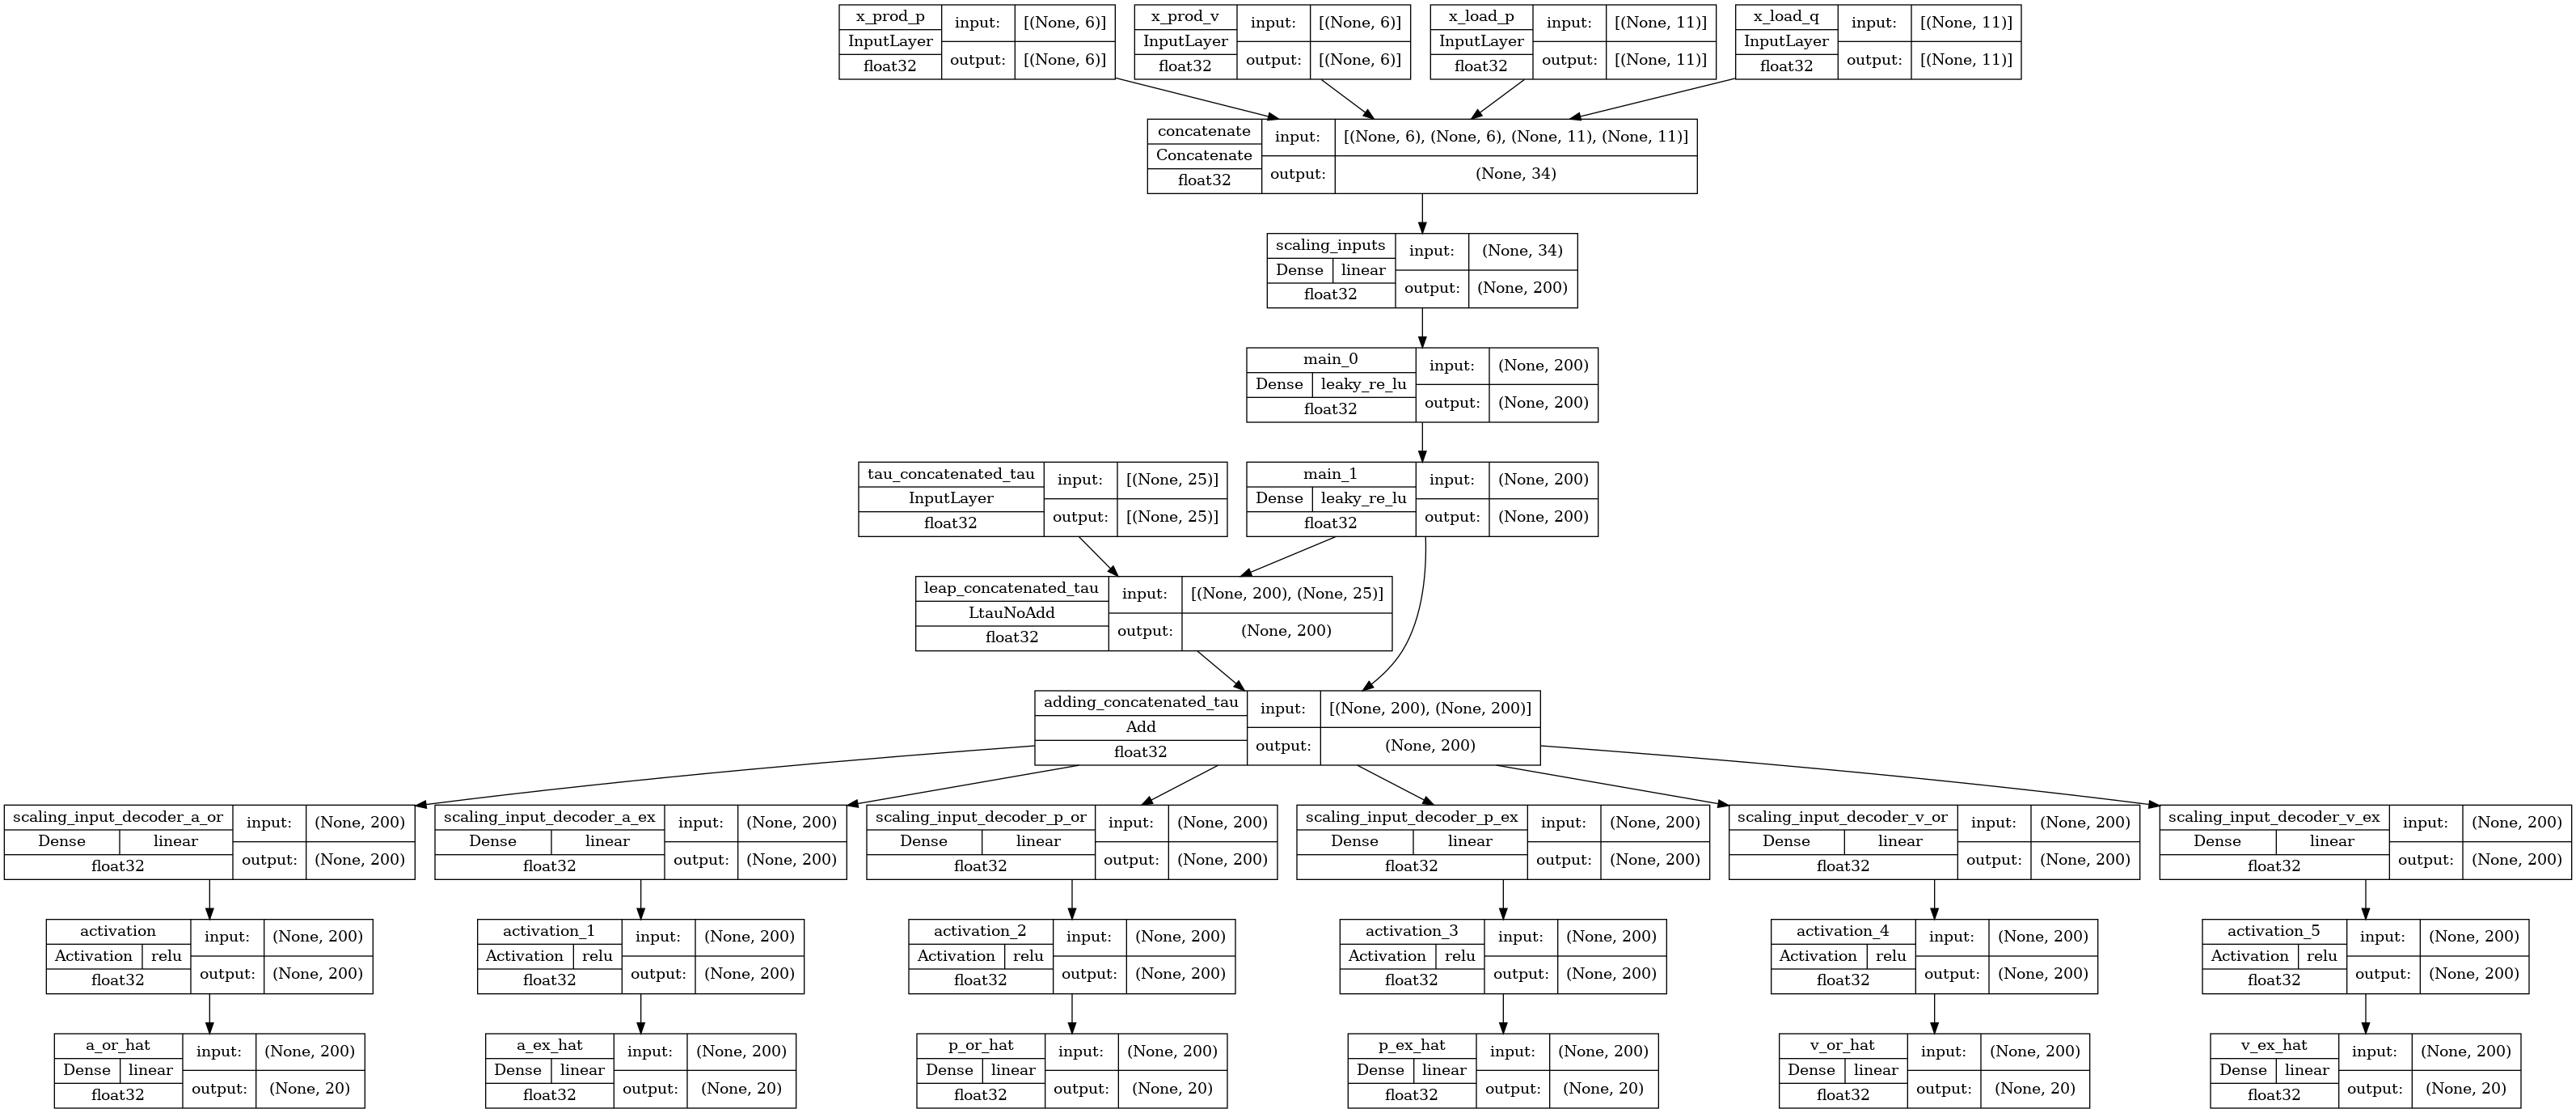

In [9]:
tf.keras.utils.plot_model(
    leap_net2._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [10]:
leap_net2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_prod_p (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 x_prod_v (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 x_load_p (InputLayer)          [(None, 11)]         0           []                               
                                                                                                  
 x_load_q (InputLayer)          [(None, 11)]         0           []                               
                                                                                              

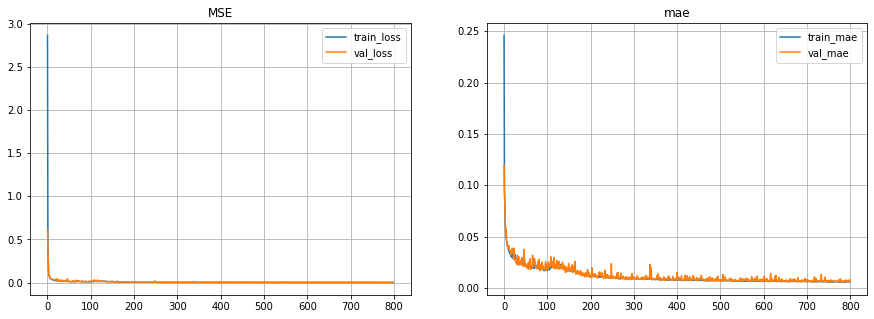

In [11]:
leap_net2.visualize_convergence()

In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark2)
leap_net2.save(SAVE_PATH)

In [ ]:
tf_leapnet_metrics2 = benchmark2.evaluate_simulator(augmented_simulator=leap_net2,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

In [ ]:
import numpy as np
eval_metrics = tf_leapnet_metrics2

## A 

In [ ]:
a_test_list = [eval_metrics["test"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test"]["ML"]["mape_90_avg"]["a_ex"]]
a_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"]]

In [ ]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_test_list), np.std(a_test_list)))
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_ood_list), np.std(a_ood_list)))

## P

In [ ]:
p_test_list = [eval_metrics["test"]["ML"]["mape_avg"]["p_or"], eval_metrics["test"]["ML"]["mape_avg"]["p_ex"]]
p_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"], eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"]]

In [ ]:
print("ML : MAPE --> P : mean :{}, std :{}".format(np.mean(p_test_list), np.std(p_test_list)))
print("OOD : MAPE --> P : mean :{}, std :{}".format(np.mean(p_ood_list), np.std(p_ood_list)))

## V 

In [ ]:
v_test_list = [eval_metrics["test"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test"]["ML"]["MAE_avg"]["v_ex"]]
v_ood_list = [eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"]]

In [ ]:
print("ML : MAE --> V : mean :{}, std :{}".format(np.mean(v_test_list), np.std(v_test_list)))
print("OOD : MAE --> V : mean :{}, std :{}".format(np.mean(v_ood_list), np.std(v_ood_list)))

## Inf speed-up

In [ ]:
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])

## Physics ML

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

## Physics OOD

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])